
# Backcasting Analysis for Transitions
Backcasting is the science of taking a desired end goal and iteratively calculating the sequence of choices which lead to it. For example if we take the end goal as a bike friendly Prague, what decisions have to be made today to reach that end goal?

### Why is this analysis so Quantitative ?
Conventional scenario analysis is often centered around narratives which break up key uncertainities. This is a time consuming process and has some important limitations. One is that it can gets very complex for more than a few uncertainities as the number of possibilties grows explosively. Two it becomes hard to keep track of all the possible decisions.

For example if we take a simplified version of this model for biking in Prague :
-  Make decisions once in 5 years.
-  6 Possible decisions or Policy Levers : Increasing Policy Coordination, Anti-Car Propaganda, Raise Prices Public Transport, Invest in Bike Infra, Lobby for Biking Finance, Levy Tax on Parking
-  Each decision can have an effect on the share of biking. But decisions also interact with each other. For example increasing policy coordination will enhance the effectiveness of all policy measures. Anti-Car Propoganda can increase the chances of un-popular measures like parking taxes.

Now if we take our end year as 2040. We have 3 sets of decisions to be made. 2^6 Possible decisions each period, for 3 periods that represents 262,144 possible transition paths. Now we have to find the ones which are successful.This is where a computational approach comes handy. We can use computers to check a vast proportion of those possible paths and precisely evaluate which ones are the best to a pre-defined criteria. In our case we have a utility function.

It also becomes possible to specify the interactions amongst decisions and delayed effects of certain decision choices. Last we can use empirical data and expert judgement to estimate the key effects and probabilties involved.


### How It Works
1. Initial Conditions: We start with the current modal split (biking, cars, public transport, and others) and set future goals for biking share.
2. Action Definition: We define a set of possible policy actions, each with specific effects, limitations, and interactions.
Mean Field Approximation: This crucial component models the aggregate response of all other agents in the system (e.g., car manufacturers, oil companies, status quo supporters) to our policy actions and changing modal shares.
State Transition Exploration: The script systematically explores all possible combinations of actions over time, creating a comprehensive map of potential futures.
Path Identification: It identifies paths that reach the desired biking share goals, considering both direct effects of actions and the Mean Field response.
6. Optimization: The script determines the most efficient path - the one that reaches the goal with the fewest actions, considering both effectiveness and societal pushback.
Visualization: It generates a graph showing the evolution of biking share over time along the optimal path, including the timing of policy actions.

### User Inputs and Their Effects
You can change various inputs to explore different scenarios:

TIME_PERIODS: Adjust the number of time steps in your analysis.

initial_modal_shares: Change the starting percentages for each transportation mode.

final_states: Modify the target biking share percentages. We have used 4% as the baseline, with 7% being realistic and 20% as the dream.

ACTIONS: You can define the full set of actions that the city can take. Note however this dramatically increases the model complexity and it might take much longer to find a solution.
For each action, you can adjust:
- effects: How much it changes each mode's share. For example raising public transport fares might increase car and bike shares.
- cooldown: How long before the action can be used again.
- one_time: Whether the action can only be used once.
- success_probability: The chance the action will work.
- interactions: How this action affects the success of other actions.
- costs: Each action can have an associated cost, for example investing in biking infrastructure is expensive and might not pay off.
- MEAN_FIELD_EFFECTS: This calculates the aggregate reaction of all other agents in the system to our policy response. In our case they represent the status quo who want to retain the current car centric modal share.

- utility_function: Change how the "goodness" of a particular modal split is calculated.Both our city and our opposition(MEAN_FEILD_EFFECTS) value the modal shift differently and have different costs for their respective actions.

- EXOGENOUS_FACTORS: Add external influences that happen at specific times. Not yet implemented but factors like E-bikes, EU policy, weather, Pandemics affect the state transtitions and can be modelled by their probabiliy distributions.


In [27]:
import itertools
import numpy as np
from collections import deque
import matplotlib.pyplot as plt


In [28]:
# ------------------------- User Input Section -------------------------

# Time periods
TIME_PERIODS = [1, 2, 3, 4]

# Define actions and their indices
DECISIONS = ['IPC', 'ACP', 'RPPT', 'IBI', 'LBF', 'LTP']
DECISION_INDICES = {name: idx for idx, name in enumerate(DECISIONS)}

# Initial modal shares (should sum to 1)
initial_modal_shares = {
    's': 0.01,  # Initial biking modal share
    'c': 0.50,  # Initial car modal share
    'p': 0.40,  # Initial public transport modal share
    'o': 0.09   # Other transport modes (calculated to sum to 1)
}
# Desired final biking modal shares
final_states = [0.20, 0.15, 0.06]  # Desired final biking modal shares

# Action definitions
class Action:
    def __init__(self, name, effects=None, cooldown=None, preparation=None, one_time=False,
                 success_probability=1.0, conditions=None, interactions=None, costs=None):
        self.name = name
        self.effects = effects if effects is not None else {}
        self.cooldown = cooldown
        self.one_time = one_time
        self.costs = costs if costs is not None else {}
        self.preparation = preparation
        self.success_probability = success_probability
        self.conditions = conditions if conditions is not None else {}
        self.interactions = interactions if interactions is not None else {}

    def evaluate_success_probability(self, executed_actions):
        probability = self.success_probability
        for interaction_action, adjustment in self.interactions.items():
            if executed_actions.get(interaction_action, 0) == 1:
                probability += adjustment
        return min(max(probability, 0.0), 1.0)

    def calculate_cost(self, executed_actions):
        cost = self.costs.get('base', 0)
        for interaction_action, adjustment in self.costs.get('interactions', {}).items():
            if executed_actions.get(interaction_action, 0) == 1:
                cost *= (1 + adjustment)
        return max(cost, 0)  # Ensure cost is non-negative

# Define the actions with their parameters
ACTIONS = {
    # Increase Policy Coordination 
    'IPC': Action(
        name='IPC',
        cooldown=2,
        costs={'base': 0.01}
    ),
    # Anti-Car Propoganda 
    'ACP': Action(
        name='ACP',
        effects={'s': 0.01, 'c': -0.005},
        cooldown=1,
        costs={'base': 0.01}
    ),
    # Raise Prices Public Transport 
    'RPPT': Action(
        name='RPPT',
        effects={'p': -0.005, 's': 0.0025, 'c': 0.0025},
        one_time=True,
        success_probability=0.2,
        interactions={
            'IPC': 0.2,
            'LBF': 0.2
        },
        costs={
            'base': 0.1,
            'interactions': {
                'LBF': -0.5,  # LBF reduces cost by 50%
                'IPC': -0.4   # IPC reduces cost by 40%
            }
        }
    ),
    # Invest in Biking Infrastructure
    'IBI': Action(
        name='IBI',
        effects={'s': 0.02, 'c': -0.01},
        one_time=True,
        success_probability=0.2,
        interactions={
            'IPC': 0.2,
            'LBF': 0.2
        },
        costs={
            'base': 0.1,
            'interactions': {
                'LBF': -0.5,  # LBF reduces cost by 50%
                'IPC': -0.4   # IPC reduces cost by 40%
            }
        }
    ),
    # Lobby for Biking Finance 
    'LBF': Action(
        name='LBF',
        cooldown=1,
        success_probability=0.2,
        interactions={
            'ACP': 0.2,
        },
        costs={'base': 0.01}
    ),
    #Levy Taxes on Car Parking 
    'LTP': Action(
        name='LTP',
        effects={'c': -0.007, 's': -0.0035, 'p': -0.0035},
        one_time=True,
        success_probability=0.2,
        interactions={
            'ACP': 0.2,
            'IPC': 0.2,
        },
        costs={
            'base': 0.01,
            'interactions': {
                'LBF': -0.5,  # LBF reduces cost by 50%
                'IPC': -0.4   # IPC reduces cost by 40%
            }
        }

    ),
    #People City Project Ghent Belgium. Pivot to pedestriants from original cycling oriented plan 
    'Super-Block' = Action(
        name = 'Super Block',
        state_requirements = if s+o > 0.2
        effects = {'c': -0.2, 's': 0.1, 'o': 0.1},
        one_time = True, 
        success_probability = 0.2,

        interatctions = {}
        costs = {
            'base' = 0.4
        } # Tipping Points 


    )
}

MEAN_FIELD_EFFECTS = {
    'base': {
        'effects': {'c': 0.005, 'p': -0.003},
        'probability': 0.8  # Base probability of the effect occurring
    },
    'reactions': {
        'ACP': {
            'effects': {'c': 0.002},
            'probability': 0.7
        },
        'LTP': {
            'effects': {'c': 0.002},
            'probability': 0.6
        },
        'RPPT': {
            'effects': {'c': 0.0025, 's': -0.0025},
            'probability': 0.5
        }
    }
}


# Utility function (for example purposes)
def utility_function(path):
    target_biking_share = min(final_states)
    total_utility = 0
    total_cost = 0
    for step in path:
        modal_shares = step['modal_shares']
        step_utility = -((modal_shares['s'] - target_biking_share) ** 2)
        total_utility += step_utility
        
        # Calculate cost for this step
        step_cost = sum(ACTIONS[DECISIONS[i]].costs['base'] for i, d in enumerate(step['decisions']) if d == 1)
        total_cost += step_cost
    
    # Normalize utility and cost to be on similar scales
    normalized_utility = total_utility / len(path)
    normalized_cost = total_cost / len(path)
    
    # Combine utility and cost (you can adjust the weights as needed)
    combined_score = normalized_utility - normalized_cost
    
    return combined_score

# Exogenous factors (if any)
EXOGENOUS_FACTORS = {
    # Define exogenous effects on modal shares (e.g., seasonal effects)
    # Time period as key, adjustments as values
    # Example: {2: {'s': 0.01, 'c': -0.005}}

    1: { # Bike Technology : EBike, Cargo Bike, Folding Bike, Shared Bikes 
        'effects': {'s': 0.01, 'c': -0.005}, # Increase effect size 
        'probability': 0.7,  # Lower this probability
        'label': 'E-Bikes'
    }, 
    2 : { # Pandemic hits
        'effects': {'s': 0.01, 'c': -0.005},
        'probability': 0.01,  # 1% chance of this factor occurring
        'label': 'Pandemic'
    },
    3 : { # EU Biking Directive passed
        'effects': {'s': 0.05, 'c': -0.005},
        'probability': 0.05,  # 1% chance of this factor occurring
        'label': 'EU Biking Directive'
    },
    4 : { #Shared Bikes + Cargo Bikes + Folding Bikes 
        'effects': {'s': 0.01, 'p' : -0.002},
        'probability': 0.8, 
        'label': 'Shared Biking'
    },
    5 : {
        'effects': {'s' : 0.5, 'p': 0.3},
        'probability': 0.0000000001,
        'label' : 'Tipping point Social Perception'

    },



    
}



Total feasible paths to desired final states: 35124

Best Path:
Time 1:
  Decisions: ['ACP']
  Modal Shares: S: 0.020, C: 0.498, P: 0.393, O: 0.089
  Cost: 0.010
  Debug Log:
    Action ACP succeeded:
      s: +0.0100
      c: -0.0050
    Mean Field Effects:
      s: +0.0000
      c: +0.0070
      p: -0.0030
      o: +0.0000
    Adjusting modal shares to sum to 1:
      s: 0.0200 -> 0.0198
      c: 0.5020 -> 0.4975
      p: 0.3970 -> 0.3935
      o: 0.0900 -> 0.0892

Time 2:
  Decisions: ['ACP']
  Modal Shares: S: 0.039, C: 0.487, P: 0.386, O: 0.088
  Cost: 0.020
  Debug Log:
    Action ACP succeeded:
      s: +0.0100
      c: -0.0050
    Mean Field Effects:
      s: +0.0000
      c: +0.0050
      p: -0.0030
      o: +0.0000
    Exogenous Effects (E-Bikes):
      s: +0.0100
      c: -0.0050
    Adjusting modal shares to sum to 1:
      s: 0.0398 -> 0.0393
      c: 0.4925 -> 0.4867
      p: 0.3905 -> 0.3858
      o: 0.0892 -> 0.0881

Time 3:
  Decisions: ['ACP']
  Modal Shares: S: 0.049

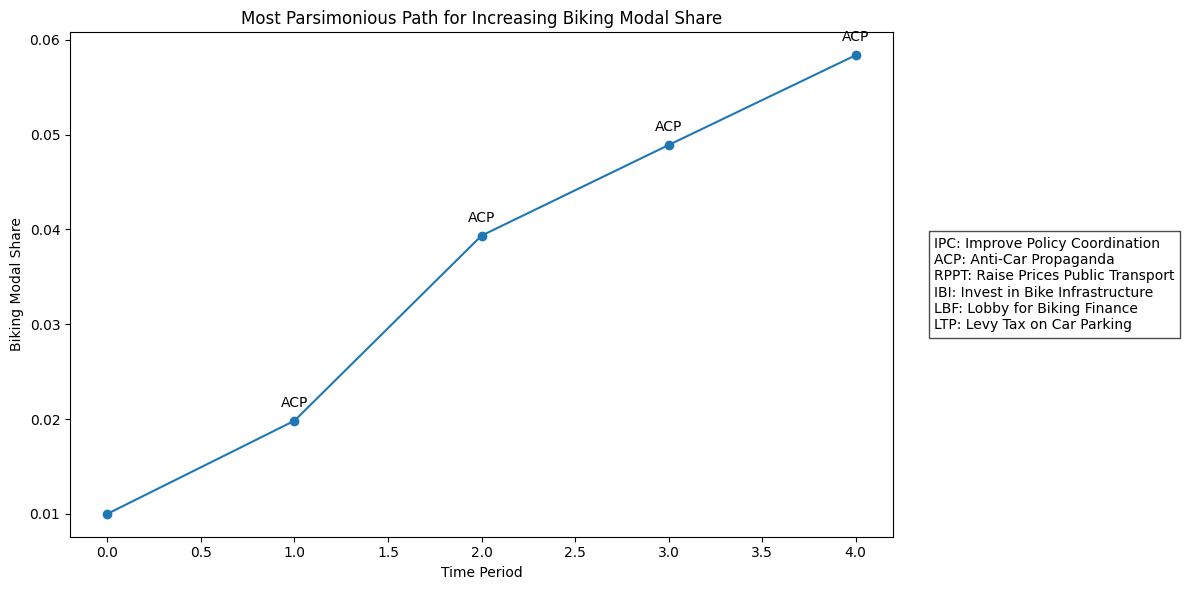

In [29]:

# ------------------------- End of User Input Section -------------------------
# State node representation
class StateNode:
    def __init__(self, time, modal_shares, decisions=None, parent=None,
                 cooldowns=None, disabled_actions=None, cost=0, debug_log=None):
        self.time = time
        self.modal_shares = modal_shares.copy()
        self.decisions = decisions
        self.parent = parent
        self.children = []
        self.cost = cost
        self.debug_log = debug_log

        if cooldowns is None:
            self.cooldowns = {action: 0 for action in DECISIONS}
        else:
            self.cooldowns = cooldowns.copy()
        if disabled_actions is None:
            self.disabled_actions = set()
        else:
            self.disabled_actions = disabled_actions.copy()
    def __repr__(self):
        modal_shares_str = ', '.join([f"{k}: {v:.3f}" for k, v in self.modal_shares.items()])
        return (f"Time: {self.time}, {modal_shares_str}, Decisions: {self.decisions}")
# Mean-field approximation for other players' response
def mean_field_response(modal_shares, decisions):
    mf_effects = {'s': 0, 'c': 0, 'p': 0, 'o': 0}
    
    # Apply base effects
    if np.random.random() < MEAN_FIELD_EFFECTS['base']['probability']:
        for mode, delta in MEAN_FIELD_EFFECTS['base']['effects'].items():
            mf_effects[mode] += delta
    
    # Apply reaction effects based on our decisions
    for action_name, reaction in MEAN_FIELD_EFFECTS['reactions'].items():
        idx = DECISION_INDICES[action_name]
        if decisions[idx]:
            if np.random.random() < reaction['probability']:
                for mode, delta in reaction['effects'].items():
                    mf_effects[mode] += delta
    
    return mf_effects

# State transition function
def state_transition(modal_shares_prev, decisions, current_time):
    modal_shares = modal_shares_prev.copy()
    executed_actions = {action_name: decisions[DECISION_INDICES[action_name]] for action_name in DECISIONS}
    actions_to_disable = set()
    total_cost = 0
    debug_log = []

    for action_name, action in ACTIONS.items():
        if executed_actions.get(action_name, 0):
            success_prob = action.evaluate_success_probability(executed_actions)
            success = np.random.rand() <= success_prob
            if success:
                debug_log.append(f"Action {action_name} succeeded:")
                for mode, delta in action.effects.items():
                    modal_shares[mode] += delta
                    debug_log.append(f"  {mode}: {delta:+.4f}")
                total_cost += action.calculate_cost(executed_actions)
            else:
                debug_log.append(f"Action {action_name} failed")
                if action.one_time:
                    actions_to_disable.add(action_name)

    mf_effects = mean_field_response(modal_shares_prev, decisions)
    debug_log.append("Mean Field Effects:")
    for mode, delta in mf_effects.items():
        modal_shares[mode] += delta
        debug_log.append(f"  {mode}: {delta:+.4f}")

    # Exogenous factors
    exogenous_effects = EXOGENOUS_FACTORS.get(current_time, {})
    if exogenous_effects:
        debug_log.append(f"Exogenous Effects ({exogenous_effects['label']}):")
        if np.random.random() < exogenous_effects['probability']:
            for mode, delta in exogenous_effects['effects'].items():
                modal_shares[mode] += delta
                debug_log.append(f"  {mode}: {delta:+.4f}")
        else:
            debug_log.append(f"  No {exogenous_effects['label']} effects applied (probability not met)")

    # Ensure modal shares sum to 1 and are within [0,1]
    total_share = sum(modal_shares.values())
    if total_share != 1:
        debug_log.append("Adjusting modal shares to sum to 1:")
        adjustment_factor = 1 / total_share
        for mode in modal_shares:
            old_share = modal_shares[mode]
            modal_shares[mode] *= adjustment_factor
            debug_log.append(f"  {mode}: {old_share:.4f} -> {modal_shares[mode]:.4f}")

    # Clip modal shares to [0,1]
    for mode in modal_shares:
        if modal_shares[mode] < 0 or modal_shares[mode] > 1:
            debug_log.append(f"Clipping {mode} from {modal_shares[mode]:.4f} to {min(max(modal_shares[mode], 0), 1):.4f}")
        modal_shares[mode] = min(max(modal_shares[mode], 0), 1)

    return modal_shares, actions_to_disable, total_cost, debug_log

def build_graph(initial_modal_shares, final_states):
    root = StateNode(time=0, modal_shares=initial_modal_shares)
    queue = deque([root])
    paths = []
    while queue:
        current_node = queue.popleft()
        if current_node.time == len(TIME_PERIODS):
            if np.isclose(current_node.modal_shares['s'], final_states, atol=0.005).any():
                path = []
                node = current_node
                while node.parent is not None:
                    path.append({
                        'time': node.time,
                        'decisions': node.decisions,
                        'modal_shares': node.modal_shares,
                        'cost': node.cost,
                        'debug_log': node.debug_log
                    })
                    node = node.parent
                path.reverse()
                paths.append(path)
            continue
        # Decrease cooldowns
        cooldowns_next = {action: max(current_node.cooldowns[action] - 1, 0) for action in DECISIONS}
        # Determine available actions
        available_actions = [action for action in DECISIONS
                             if cooldowns_next[action] == 0 and action not in current_node.disabled_actions]

       # Generate all possible combinations of available actions (power set)
        action_combinations = []
        for r in range(len(available_actions) + 1):
            action_combinations.extend(itertools.combinations(available_actions, r))
        # For each combination, create the decision vector
        for action_subset in action_combinations:
            decisions = [0] * len(DECISIONS)
            for action in action_subset:
                idx = DECISION_INDICES[action]
                decisions[idx] = 1

            modal_shares_next, actions_to_disable, step_cost, debug_log = state_transition(
                current_node.modal_shares,
                decisions,
                current_node.time  # Pass the current time to state_transition
            )
            # Update cooldowns and disabled actions
            cooldowns_updated = cooldowns_next.copy()
            disabled_actions_updated = current_node.disabled_actions.copy()
            # Set cooldowns and disable actions as needed
            for action in action_subset:
                action_obj = ACTIONS[action]
                idx = DECISION_INDICES[action]
                # Set cooldown if action has a cooldown
                if action_obj.cooldown is not None:
                    cooldowns_updated[action] = action_obj.cooldown
                # Disable one-time actions
                if action_obj.one_time:
                    disabled_actions_updated.add(action)
            # Disable actions that failed
            disabled_actions_updated.update(actions_to_disable)
            # Create child node
            child_node = StateNode(
                time=current_node.time + 1,
                modal_shares=modal_shares_next,
                decisions=decisions,
                parent=current_node,
                cooldowns=cooldowns_updated,
                disabled_actions=disabled_actions_updated,
                cost=current_node.cost + step_cost,
                debug_log=debug_log
            )
            current_node.children.append(child_node)
            queue.append(child_node)

    return paths

# Execute the graph building
paths = build_graph(initial_modal_shares, final_states)

# Display the results
print(f"Total feasible paths to desired final states: {len(paths)}\n")
# Find and visualize the most parsimonious path

def evaluate_path(path):
    utility = utility_function(path)
  # Negative because we want to maximize utility but minimize decisions
    return utility 

def find_best_path(paths):
    if not paths:
        return None
    return max(paths, key=evaluate_path)

def visualize_best_path(path):
    times = [0] + [step['time'] for step in path]
    shares = [initial_modal_shares['s']] + [step['modal_shares']['s'] for step in path]
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(times, shares, marker='o')
    for i, step in enumerate(path):
        decision_names = [DECISIONS[i] for i, d in enumerate(step['decisions']) if d == 1]
        if decision_names:
            ax.annotate(', '.join(decision_names), (step['time'], step['modal_shares']['s']), 
                        textcoords="offset points", xytext=(0,10), ha='center')
    ax.set_xlabel('Time Period')
    ax.set_ylabel('Biking Modal Share')
    ax.set_title('Best Path for Increasing Biking Modal Share')
    # Add legend
    legend_text = '\n'.join([f"{abbr}: {name}" for abbr, name in zip(DECISIONS, [       
        "Improve Policy Coordination",
        "Anti-Car Propaganda",
        "Raise Prices Public Transport",
        "Invest in Bike Infrastructure",
        "Lobby for Biking Finance",
        "Levy Tax on Car Parking"
    ])])
        
    ax.text(1.05, 0.5, legend_text, transform=ax.transAxes, 
            bbox=dict(facecolor='white', edgecolor='black', alpha=0.7),
            verticalalignment='center')
    plt.tight_layout()
    plt.show()
best_path = find_best_path(paths)


if best_path:
    print("Best Path:")
    for step in best_path:
        decision_names = [DECISIONS[i] for i, d in enumerate(step['decisions']) if d == 1]
        modal_shares_str = ', '.join([f"{k.upper()}: {v:.3f}" for k, v in step['modal_shares'].items()])
        print(f"Time {step['time']}:")
        print(f"  Decisions: {decision_names}")
        print(f"  Modal Shares: {modal_shares_str}")
        print(f"  Cost: {step['cost']:.3f}")
        print("  Debug Log:")
        for log_entry in step['debug_log']:
            print(f"    {log_entry}")
        print()
    visualize_best_path(best_path)
else:
    print("No feasible paths found.")

Final Biking Share: Mean = 0.0619, Std Dev = 0.0033
95% Confidence Interval for Final Biking Share: (0.05189389982949513, 0.07183782463128897)
Utility: Mean = -0.0083, Std Dev = 0.0010
95% Confidence Interval for Utility: (-0.011201150533414129, -0.005301834687321108)


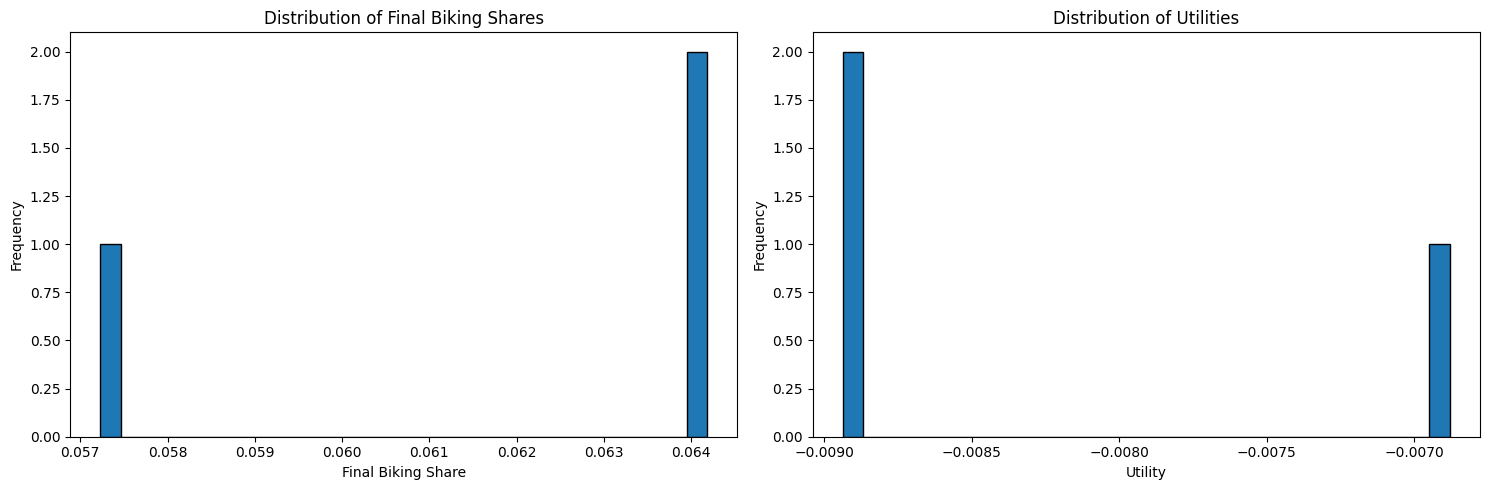

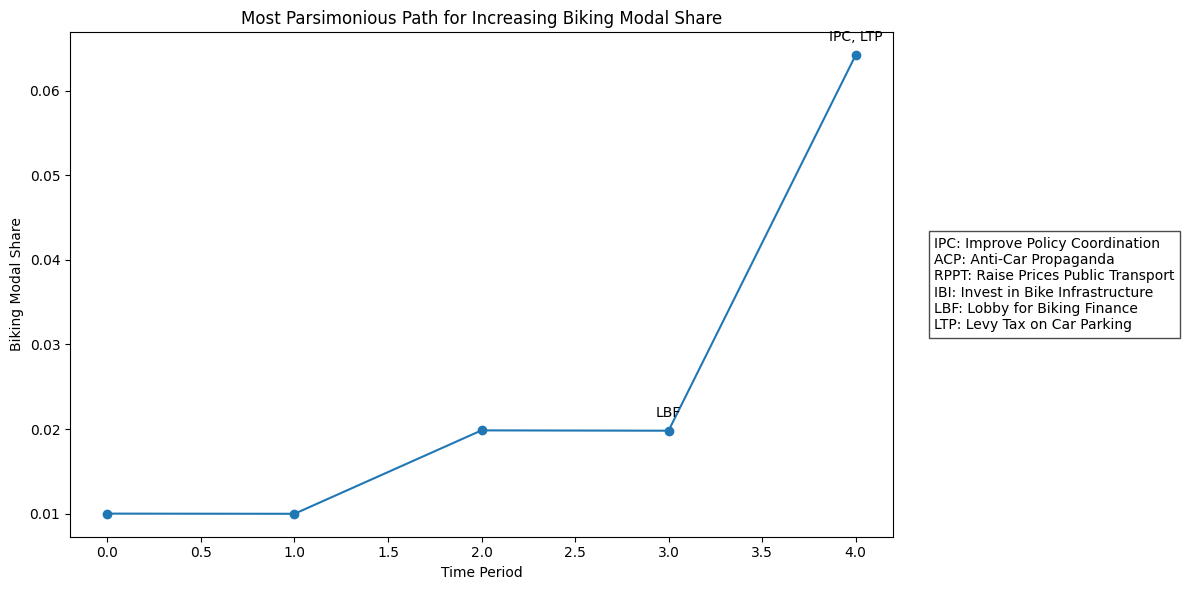

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def run_monte_carlo_simulation(num_runs=3):
    all_best_paths = []
    all_final_shares = []
    all_utilities = []

    for _ in range(num_runs):
        paths = build_graph(initial_modal_shares, final_states)
        best_path = find_best_path(paths)
        if best_path:
            all_best_paths.append(best_path)
            all_final_shares.append(best_path[-1]['modal_shares']['s'])
            all_utilities.append(evaluate_path(best_path))

    return all_best_paths, all_final_shares, all_utilities

def analyze_results(all_final_shares, all_utilities):
    # Calculate statistics
    mean_share = np.mean(all_final_shares)
    std_share = np.std(all_final_shares)
    ci_share = stats.t.interval(0.95, len(all_final_shares)-1, loc=mean_share, scale=stats.sem(all_final_shares))

    mean_utility = np.mean(all_utilities)
    std_utility = np.std(all_utilities)
    ci_utility = stats.t.interval(0.95, len(all_utilities)-1, loc=mean_utility, scale=stats.sem(all_utilities))

    # Print results
    print(f"Final Biking Share: Mean = {mean_share:.4f}, Std Dev = {std_share:.4f}")
    print(f"95% Confidence Interval for Final Biking Share: {ci_share}")
    print(f"Utility: Mean = {mean_utility:.4f}, Std Dev = {std_utility:.4f}")
    print(f"95% Confidence Interval for Utility: {ci_utility}")

    # Visualize distributions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.hist(all_final_shares, bins=30, edgecolor='black')
    ax1.set_title('Distribution of Final Biking Shares')
    ax1.set_xlabel('Final Biking Share')
    ax1.set_ylabel('Frequency')

    ax2.hist(all_utilities, bins=30, edgecolor='black')
    ax2.set_title('Distribution of Utilities')
    ax2.set_xlabel('Utility')
    ax2.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Run the Monte Carlo simulation
num_runs = 3  # You can adjust this number based on your computational resources
all_best_paths, all_final_shares, all_utilities = run_monte_carlo_simulation(num_runs)

# Analyze and visualize the results
analyze_results(all_final_shares, all_utilities)

# Optionally, visualize the most common best path
from collections import Counter

def most_common_path(all_best_paths):
    path_strings = [''.join(str(d) for d in path[-1]['decisions']) for path in all_best_paths]
    most_common = Counter(path_strings).most_common(1)[0][0]
    return next(path for path in all_best_paths if ''.join(str(d) for d in path[-1]['decisions']) == most_common)

common_best_path = most_common_path(all_best_paths)
visualize_best_path(common_best_path)